In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


Importing Data

In [2]:
store_sales_data = pd.read_csv("data/sales-data.csv")
store_sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Data Cleaning - Checking for Null Values

In [3]:
store_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Dropping stores and Item columns, since we are only concerned with the price and the respective date which is needed to forecast

In [8]:
store_sales_data = store_sales_data.drop(['store', 'item'], axis=1)

KeyError: "['store', 'item'] not found in axis"

In [7]:
store_sales_data['date'] = pd.to_datetime(store_sales_data['date'])
store_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Since we are forecasting sales in the future, we can aggregate the individual data of each month and forecast on the basis of each month

In [9]:
store_sales_data['date'] = store_sales_data['date'].dt.to_period("M")
monthly_sales_data = store_sales_data.groupby('date').sum().reset_index()

In [15]:
monthly_sales_data['date'] = monthly_sales_data['date'].dt.to_timestamp()

In [16]:
monthly_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    60 non-null     datetime64[ns]
 1   sales   60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


Visualization

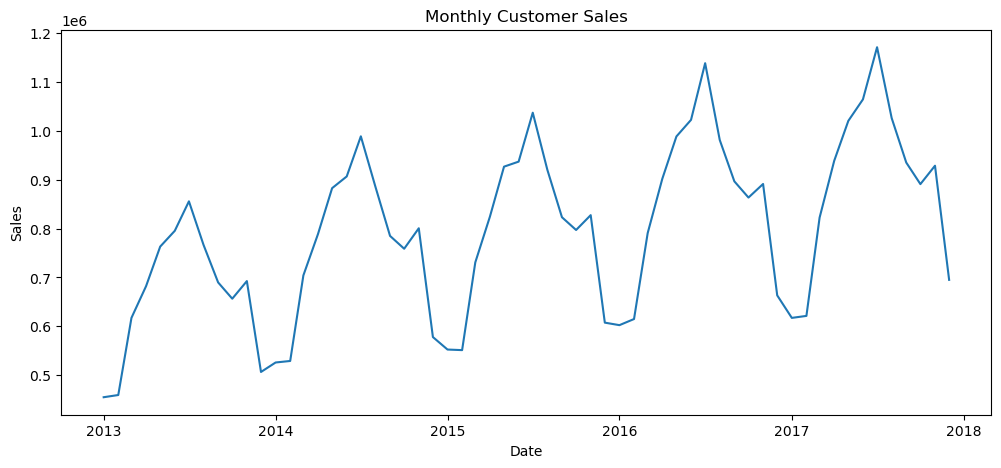

In [18]:
plt.figure(figsize=(12,5))
plt.plot(monthly_sales_data['date'], monthly_sales_data['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

To smoothen out the graph variations, we can take the difference of sales from each period to see if it's increasing or decreasing and then, visualize that.

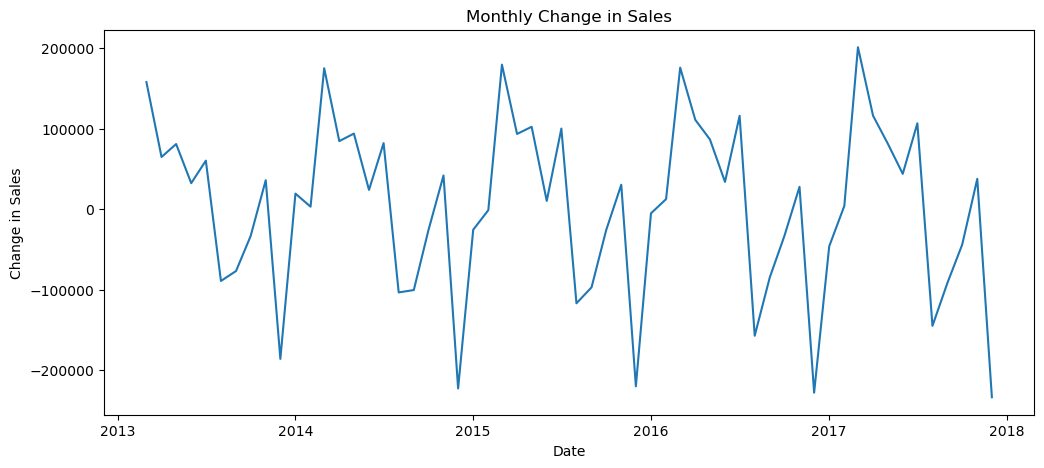

In [20]:
monthly_sales_data['sales_diff'] = monthly_sales_data['sales'].diff()
monthly_sales_data = monthly_sales_data.dropna() # we do this because in some periods, if we do not have data from the past period, we may get a NA

plt.figure(figsize=(12,5))
plt.plot(monthly_sales_data['date'], monthly_sales_data['sales_diff'])
plt.xlabel('Date')
plt.ylabel('Change in Sales')
plt.title('Monthly Change in Sales')
plt.show()

In [22]:
supervised_learning = monthly_sales_data.drop(['sales', 'date'], axis=1)


Since we removed the date and its corresponding sales, we will need to prepare the sales diff data in a way to correspond to each month holding static data

In [23]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_learning[col_name] = supervised_learning['sales_diff'].shift(i)
supervised_learning = supervised_learning.dropna().reset_index(drop=True)
supervised_learning.head()

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
1,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
2,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
3,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
4,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0


Split the data into training data and test data

In [24]:
training_data = supervised_learning[:-12]
testing_data = supervised_learning[-12:]

In [26]:
scaler = MinMaxScaler(feature_range=(-1,1)) # using Minmax scaler to scale the training values from -1 to 1
scaler.fit(training_data)
training_data = scaler.transform(training_data)
testing_data = scaler.transform(testing_data)

In [27]:
x_train, y_train = training_data[:,1:], training_data[:,0:1]
x_test, y_test = testing_data[:,1:], testing_data[:,0:1]

In [28]:
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (34, 12)
y_train shape:  (34,)
x_test shape:  (12, 12)
y_test shape:  (12,)


Make a prediction data frame to merge the predicted sales prices of all the trained algorithms

In [29]:
sales_dates = monthly_sales_data['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
actual_sales = monthly_sales_data['sales'][-13:].to_list()

To create the linear regression prediction and the linear regression model

In [31]:
linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)
linear_regressor_predictor = linear_regressor.predict(x_test)

linear_regressor_predictor = linear_regressor_predictor.reshape(-1,1)
lr_predictor_test_set = np.concatenate([linear_regressor_predictor, x_test], axis=1) #contains input features of test data & predicted output
lr_predictor_test_set = scaler.inverse_transform(lr_predictor_test_set)

In [32]:
result_list = []
for index in range(0, len(lr_predictor_test_set)):
    result_list.append(lr_predictor_test_set[index][0] + actual_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)